# Stage 4: Clustering (Unconstrained Exploration)

**Primary author:** Victoria
**Builds on:**
- *Hierarchical_Clustering_Indicators_with_BGE_M3_Embeddings.ipynb* (Victoria — HDBSCAN; Sahana — agglomerative/Ward's)
- *NC_Indicators_wo_Context_Clustered_Embeddings_Compared.ipynb* (Nathan — DBSCAN, EmbeddingComparison framework, silhouette evaluation)
- `03_dimensionality_reduction.ipynb` (Stage 3 output: UMAP embeddings)

**Prompt engineering:** Victoria
**AI assistance:** Claude (Anthropic)
**Environment:** Great Lakes for parameter sweeps, Colab for single runs

**Research question: "What structure emerges when we let the algorithms find it
without guidance?"**

This notebook applies unsupervised clustering to the 10-dimensional UMAP embeddings
of 12,622 verified CCC indicators. We deliberately do NOT use domain knowledge (seed
words, wordplay type labels, or expert-defined categories) to guide clustering here.
The goal is to discover what structure the embedding space reveals on its own.

Two clustering approaches are used:

1. **HDBSCAN** — a density-based method that discovers clusters of varying density
   and automatically determines the number of clusters. Requires an epsilon
   sensitivity analysis (per KCT, Feb 15).
2. **Agglomerative clustering with Ward's method** — a hierarchical method that
   merges clusters bottom-up using global variance statistics. We explore multiple
   values of k (number of clusters) spanning coarse to fine granularity.

Domain knowledge and labeled evaluation are introduced in Notebook 05 (constrained
and targeted experiments) and Notebook 06 (evaluation and report figures).

## Running on Google Colab

If running on Google Colab:

1. Go to **Runtime > Change runtime type**
2. A GPU is not required for clustering, but will speed up UMAP if you need to
   regenerate embeddings
3. Click **Save**, then run all cells

For parameter sweeps (many HDBSCAN runs), Great Lakes is recommended.
Single clustering runs complete in seconds on any hardware.

---
## Section 1: Setup and Data Preparation

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

import hdbscan  # install via: pip install hdbscan

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 120

np.random.seed(42)

### Environment Auto-Detection and Paths

In [2]:
# --- Environment Auto-Detection ---
try:
    IS_COLAB = 'google.colab' in str(get_ipython())
except NameError:
    IS_COLAB = False

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = Path('/content/drive/MyDrive/SIADS 692 Milestone II/Milestone II - NLP Cryptic Crossword Clues')
else:
    try:
        PROJECT_ROOT = Path(__file__).resolve().parent.parent
    except NameError:
        PROJECT_ROOT = Path.cwd().parent

DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')
print(f'Data directory: {DATA_DIR}')
print(f'Output directory: {OUTPUT_DIR}')
print(f'Figures directory: {FIGURES_DIR}')

Project root: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering
Data directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/data
Output directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs
Figures directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures


### Input File Validation

Before proceeding, we verify that all required input files from earlier stages exist.
These are:

| File | Produced by | Description |
|------|-------------|-------------|
| `embeddings_umap_10d.npy` | Stage 3 | 10D UMAP embeddings for clustering |
| `embeddings_umap_2d.npy` | Stage 3 | 2D UMAP embeddings for visualization |
| `indicator_index_all.csv` | Stage 2 | Row-to-indicator-string mapping |

Note: This notebook does NOT load `verified_clues_labeled.csv` (wordplay labels).
Label-based evaluation is deferred to Notebooks 05 and 06.

In [4]:
required_files = {
    'embeddings_umap_10d.npy': 'Run 03_dimensionality_reduction.ipynb (Stage 3)',
    'embeddings_umap_2d.npy': 'Run 03_dimensionality_reduction.ipynb (Stage 3)',
    'indicator_index_all.csv': 'Run 02_embedding_generation.ipynb (Stage 2)',
}

for fname, fix_msg in required_files.items():
    fpath = DATA_DIR / fname
    assert fpath.exists(), (
        f'Missing required file: {fpath}\n'
        f'Fix: {fix_msg}'
    )

print('All input files found:')
for fname in required_files:
    print(f'  {fname}')

All input files found:
  embeddings_umap_10d.npy
  embeddings_umap_2d.npy
  indicator_index_all.csv


### Load Input Files

In [5]:
# Load UMAP embeddings
embeddings_10d = np.load(DATA_DIR / 'embeddings_umap_10d.npy')
embeddings_2d = np.load(DATA_DIR / 'embeddings_umap_2d.npy')

# Load indicator index (maps row i -> indicator string)
df_index = pd.read_csv(DATA_DIR / 'indicator_index_all.csv', index_col=0)
indicator_col = df_index.columns[0]  # should be 'indicator'
indicator_names = df_index[indicator_col].values  # numpy array for fast indexing

print(f'10D embeddings shape: {embeddings_10d.shape}')
print(f'2D embeddings shape:  {embeddings_2d.shape}')
print(f'Indicator index rows: {len(df_index)}')

# Sanity checks
n_indicators = len(df_index)
assert embeddings_10d.shape == (n_indicators, 10), (
    f'Expected 10D shape ({n_indicators}, 10), got {embeddings_10d.shape}'
)
assert embeddings_2d.shape == (n_indicators, 2), (
    f'Expected 2D shape ({n_indicators}, 2), got {embeddings_2d.shape}'
)
print(f'\nShape checks passed: {n_indicators:,} indicators')

10D embeddings shape: (12622, 10)
2D embeddings shape:  (12622, 2)
Indicator index rows: 12622

Shape checks passed: 12,622 indicators


---
## Section 2: Pairwise Distance Analysis

**Why this step is necessary:** HDBSCAN's `cluster_selection_epsilon` parameter defines
a distance threshold below which clusters will be merged. If we choose an epsilon of 0.5
but all pairwise distances in our data are between 0.01 and 0.05, that epsilon is
meaninglessly large — it would merge everything into one cluster. Conversely, an epsilon
of 0.001 in that same data would have no effect. **Without knowing the actual distance
scale, any epsilon choice is arbitrary.**

Following KCT's guidance (Feb 15 meeting): "Take a look at typical pairwise distances,
get a distribution, pick a value of epsilon based on that."

We compute pairwise Euclidean distances on a random sample of 2,000 points from the
10D UMAP embeddings. Using all 12,622 points would produce ~80 million distance pairs
(12,622 × 12,621 / 2), which is computationally expensive. A sample of 2,000 gives
~2 million pairs — more than enough to characterize the distribution.

**Note on distance metric:** HDBSCAN uses Euclidean distance by default, and our 10D
UMAP embeddings were produced with `metric='cosine'` — meaning UMAP already arranged
the points so that cosine-similar items are Euclidean-close in the reduced space. So
Euclidean distance in UMAP space is appropriate here.

In [6]:
# Sample 2,000 points for pairwise distance computation
sample_size = 2000
rng = np.random.RandomState(42)
sample_idx = rng.choice(len(embeddings_10d), size=sample_size, replace=False)
sample_embeddings = embeddings_10d[sample_idx]

# Compute pairwise Euclidean distances (returns condensed form)
# pdist returns a 1D array of all unique pairs
pairwise_dists = pdist(sample_embeddings, metric='euclidean')

print(f'Sample size: {sample_size}')
print(f'Number of pairwise distances: {len(pairwise_dists):,}')
print(f'\nDistance statistics:')
print(f'  Min:    {pairwise_dists.min():.4f}')
print(f'  Max:    {pairwise_dists.max():.4f}')
print(f'  Mean:   {pairwise_dists.mean():.4f}')
print(f'  Median: {np.median(pairwise_dists):.4f}')
print(f'  Std:    {pairwise_dists.std():.4f}')

# Key percentiles — these will guide epsilon selection
percentiles = [5, 10, 25, 50, 75, 90, 95]
percentile_values = np.percentile(pairwise_dists, percentiles)

print(f'\nKey percentiles:')
for p, v in zip(percentiles, percentile_values):
    print(f'  {p:3d}th percentile: {v:.4f}')

Sample size: 2000
Number of pairwise distances: 1,999,000

Distance statistics:
  Min:    0.0025
  Max:    8.5080
  Mean:   3.5617
  Median: 3.5518
  Std:    1.2452

Key percentiles:
    5th percentile: 1.4980
   10th percentile: 1.9327
   25th percentile: 2.6847
   50th percentile: 3.5518
   75th percentile: 4.4582
   90th percentile: 5.2181
   95th percentile: 5.5993


### Distance Distribution Histogram

The histogram below shows the distribution of all pairwise Euclidean distances in the
2,000-point sample. Vertical lines mark key percentiles. The shape of this distribution
tells us:

- **If unimodal and tight:** Most points are at similar distances — the data is
  relatively uniform, and clustering will be sensitive to epsilon.
- **If multimodal or with a long tail:** There are distinct distance scales — some
  points are much closer to each other than to the bulk, suggesting natural clusters.
- **Where the bulk of the distribution sits:** This sets the scale for epsilon selection.

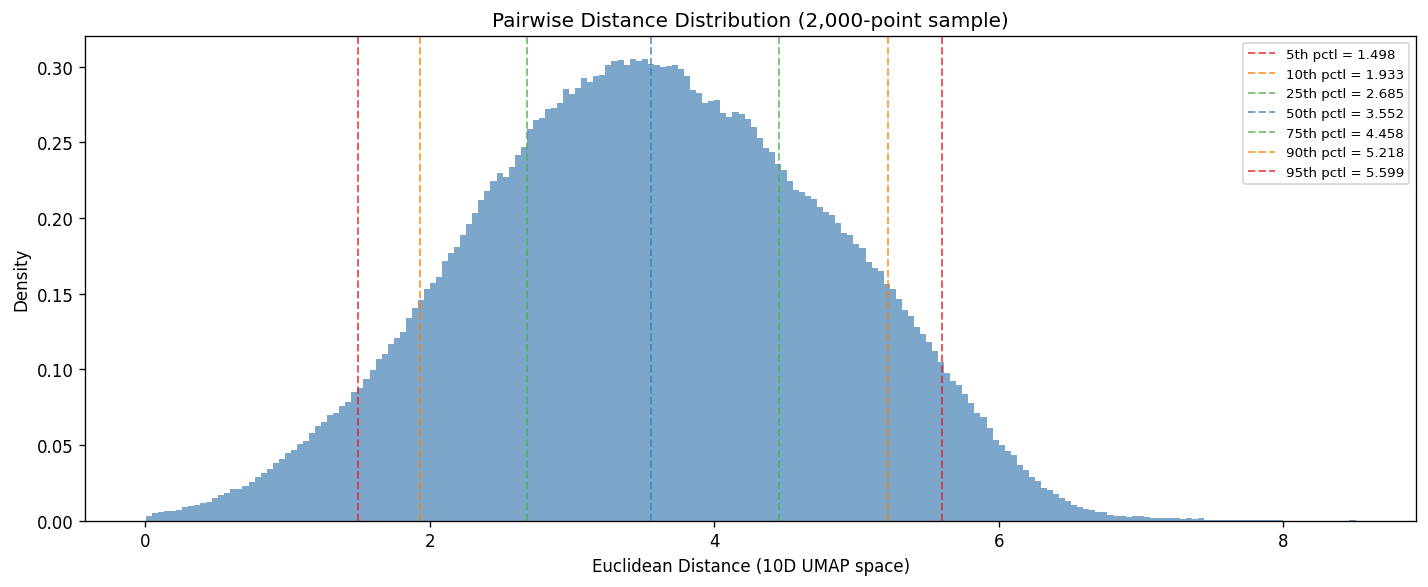

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/pairwise_distance_distribution.png


In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(pairwise_dists, bins=200, color='steelblue', alpha=0.7, edgecolor='none',
        density=True)

# Mark key percentiles
colors_pctl = ['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8', '#4daf4a', '#ff7f00', '#e41a1c']
for p, v, c in zip(percentiles, percentile_values, colors_pctl):
    ax.axvline(v, color=c, linestyle='--', alpha=0.7, linewidth=1.2,
               label=f'{p}th pctl = {v:.3f}')

ax.set_xlabel('Euclidean Distance (10D UMAP space)')
ax.set_ylabel('Density')
ax.set_title('Pairwise Distance Distribution (2,000-point sample)')
ax.legend(fontsize=8, loc='upper right')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'pairwise_distance_distribution.png', dpi=150,
            bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURES_DIR / "pairwise_distance_distribution.png"}')

---
## Section 3: HDBSCAN with Epsilon Sensitivity Analysis

### What is HDBSCAN?

**HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)**
is a density-based clustering algorithm. Unlike k-means, it does not require the number
of clusters to be specified in advance — it discovers clusters of varying density
automatically. Points in low-density regions are labeled as "noise" (cluster label = -1)
rather than being forced into the nearest cluster.

### Key Parameters

- **`min_cluster_size`** — The minimum number of points required to form a cluster.
  We use 10, meaning any group of fewer than 10 nearby indicators is treated as noise
  rather than a cluster. This prevents tiny, meaningless clusters.

- **`cluster_selection_epsilon`** — A distance threshold for cluster merging. When two
  clusters are closer than epsilon, HDBSCAN merges them into one. Larger epsilon values
  produce fewer, larger clusters; smaller values produce more, finer-grained clusters.
  **This is the parameter we will sweep** across values informed by the distance
  distribution in Section 2.

### Interpreting the Sensitivity Analysis

We run HDBSCAN at several epsilon values and track:
- **Number of clusters found** — How granularity changes with epsilon
- **Noise percentage** — How many points are left unassigned
- **Silhouette score** — Measures how similar each point is to its own cluster vs.
  the nearest other cluster (-1 to 1; higher is better). Computed on non-noise
  points only.
- **Davies-Bouldin index** — Measures the average similarity between each cluster
  and its most similar cluster (lower is better).

**Stability interpretation:** If metrics change dramatically with small epsilon changes,
the cluster structure is **fragile** — it depends sensitively on a parameter choice
rather than reflecting genuine structure. If metrics are stable across a range of epsilon
values, the structure is **robust** and we can be more confident in the results.

### Select Epsilon Candidates

We choose epsilon candidates based on the distance distribution percentiles computed
above. The candidates span from a small value (which will produce many fine-grained
clusters) to a larger value (which will merge clusters aggressively). We also include
0.0 as a baseline (no merging — pure HDBSCAN without epsilon smoothing).

In [8]:
# Select epsilon candidates from the distance distribution
# We use percentiles of the pairwise distance distribution as a principled basis.
# The candidates range from 0.0 (no epsilon merging) to around the 25th percentile.
# Values beyond the median would merge nearly everything.
epsilon_candidates = [
    0.0,                                            # baseline: no epsilon merging
    float(np.percentile(pairwise_dists, 1)),        # ~1st percentile
    float(np.percentile(pairwise_dists, 5)),        # ~5th percentile
    float(np.percentile(pairwise_dists, 10)),       # ~10th percentile
    float(np.percentile(pairwise_dists, 15)),       # ~15th percentile
    float(np.percentile(pairwise_dists, 20)),       # ~20th percentile
    float(np.percentile(pairwise_dists, 25)),       # ~25th percentile
]

# Round for cleaner display
epsilon_candidates = [round(e, 4) for e in epsilon_candidates]

print('Epsilon candidates for HDBSCAN sweep:')
for i, eps in enumerate(epsilon_candidates):
    print(f'  {i+1}. epsilon = {eps}')

Epsilon candidates for HDBSCAN sweep:
  1. epsilon = 0.0
  2. epsilon = 0.7788
  3. epsilon = 1.498
  4. epsilon = 1.9327
  5. epsilon = 2.2334
  6. epsilon = 2.4729
  7. epsilon = 2.6847


### Run HDBSCAN Sweep

For each epsilon value, we run HDBSCAN on the 10D UMAP embeddings and record
clustering metrics. Silhouette and Davies-Bouldin scores are computed on non-noise
points only (since noise points have no cluster assignment). This is standard practice
but means that a run with very high noise (few clustered points) can have a deceptively
high silhouette score — we must examine noise percentage alongside silhouette.

In [9]:
hdbscan_results = []
hdbscan_labels_dict = {}  # store labels for each epsilon

for eps in epsilon_candidates:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=10,
        cluster_selection_epsilon=eps,
        metric='euclidean',
        core_dist_n_jobs=-1,
    )
    labels = clusterer.fit_predict(embeddings_10d)
    hdbscan_labels_dict[eps] = labels

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    noise_pct = n_noise / len(labels) * 100

    # Compute metrics on non-noise points only
    non_noise_mask = labels != -1
    n_clustered = non_noise_mask.sum()

    if n_clusters >= 2 and n_clustered >= 2:
        sil = silhouette_score(embeddings_10d[non_noise_mask], labels[non_noise_mask])
        db = davies_bouldin_score(embeddings_10d[non_noise_mask], labels[non_noise_mask])
    else:
        sil = float('nan')
        db = float('nan')

    hdbscan_results.append({
        'epsilon': eps,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_pct': noise_pct,
        'n_clustered': n_clustered,
        'silhouette': sil,
        'davies_bouldin': db,
    })

    print(f'eps={eps:.4f}: {n_clusters:4d} clusters, '
          f'{n_noise:5d} noise ({noise_pct:5.1f}%), '
          f'silhouette={sil:.3f}, DB={db:.3f}')

df_hdbscan = pd.DataFrame(hdbscan_results)
print('\n--- HDBSCAN Sweep Summary ---')
print(df_hdbscan.to_string(index=False))

eps=0.0000:  282 clusters,  4212 noise ( 33.4%), silhouette=0.631, DB=0.470
eps=0.7788:   11 clusters,   114 noise (  0.9%), silhouette=-0.186, DB=0.775
eps=1.4980:    4 clusters,     0 noise (  0.0%), silhouette=0.230, DB=0.549
eps=1.9327:    4 clusters,     0 noise (  0.0%), silhouette=0.230, DB=0.549
eps=2.2334:    3 clusters,     0 noise (  0.0%), silhouette=0.386, DB=0.461
eps=2.4729:    3 clusters,     0 noise (  0.0%), silhouette=0.386, DB=0.461
eps=2.6847:    3 clusters,     0 noise (  0.0%), silhouette=0.386, DB=0.461

--- HDBSCAN Sweep Summary ---
 epsilon  n_clusters  n_noise  noise_pct  n_clustered  silhouette  davies_bouldin
  0.0000         282     4212  33.370306         8410    0.630992        0.470028
  0.7788          11      114   0.903185        12508   -0.185984        0.775157
  1.4980           4        0   0.000000        12622    0.230049        0.549086
  1.9327           4        0   0.000000        12622    0.230049        0.549086
  2.2334           3      

### Sensitivity Plot

The plot below shows how three key metrics change as epsilon increases. This is the
sensitivity analysis KCT requested. We look for:

- **Stable regions:** Where metrics plateau, indicating robust structure
- **Sharp transitions:** Where a small epsilon change causes large metric jumps,
  indicating fragile structure at that scale
- **Trade-offs:** More clusters typically means more noise points but potentially
  higher silhouette (tighter individual clusters)

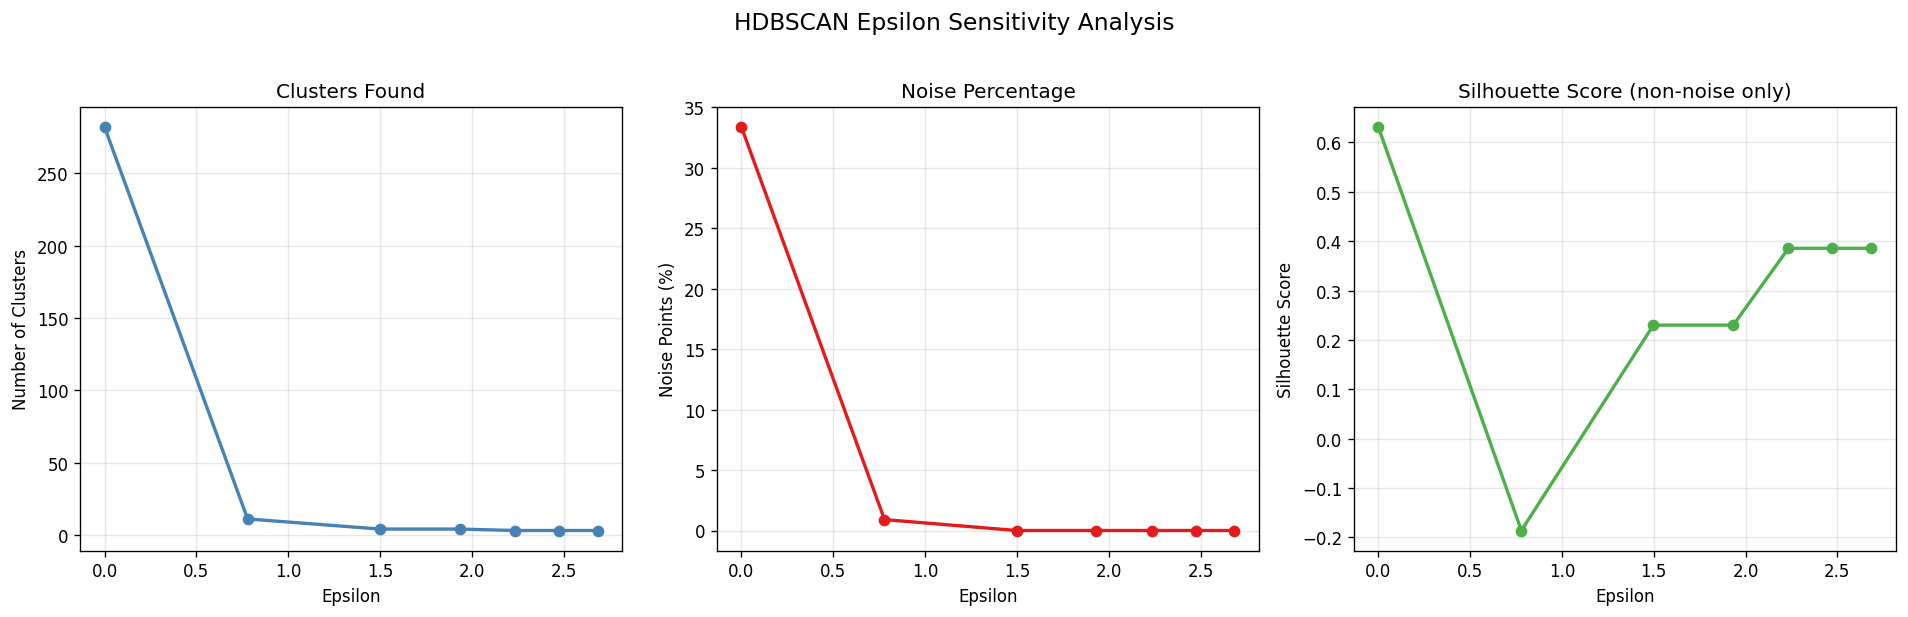

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/hdbscan_epsilon_sensitivity.png


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Number of clusters
axes[0].plot(df_hdbscan['epsilon'], df_hdbscan['n_clusters'],
             'o-', color='steelblue', linewidth=2, markersize=6)
axes[0].set_xlabel('Epsilon')
axes[0].set_ylabel('Number of Clusters')
axes[0].set_title('Clusters Found')
axes[0].grid(True, alpha=0.3)

# Panel 2: Noise percentage
axes[1].plot(df_hdbscan['epsilon'], df_hdbscan['noise_pct'],
             'o-', color='#e41a1c', linewidth=2, markersize=6)
axes[1].set_xlabel('Epsilon')
axes[1].set_ylabel('Noise Points (%)')
axes[1].set_title('Noise Percentage')
axes[1].grid(True, alpha=0.3)

# Panel 3: Silhouette score
axes[2].plot(df_hdbscan['epsilon'], df_hdbscan['silhouette'],
             'o-', color='#4daf4a', linewidth=2, markersize=6)
axes[2].set_xlabel('Epsilon')
axes[2].set_ylabel('Silhouette Score')
axes[2].set_title('Silhouette Score (non-noise only)')
axes[2].grid(True, alpha=0.3)

plt.suptitle('HDBSCAN Epsilon Sensitivity Analysis', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'hdbscan_epsilon_sensitivity.png', dpi=150,
            bbox_inches='tight')
plt.show()

print(f'Saved: {FIGURES_DIR / "hdbscan_epsilon_sensitivity.png"}')

### Identify Best HDBSCAN Run

We select the HDBSCAN run with the highest silhouette score as the "best" run for
visualization and qualitative inspection later in this notebook. This is a pragmatic
choice — silhouette score is not the only criterion, and we save all runs so that
Notebook 05 can compare them more thoroughly.

In [11]:
best_hdbscan_idx = df_hdbscan['silhouette'].idxmax()
best_hdbscan_row = df_hdbscan.loc[best_hdbscan_idx]
best_eps = best_hdbscan_row['epsilon']
best_hdbscan_labels = hdbscan_labels_dict[best_eps]

print(f'Best HDBSCAN run by silhouette score:')
print(f'  Epsilon:    {best_eps}')
print(f'  Clusters:   {int(best_hdbscan_row["n_clusters"])}')
print(f'  Noise:      {int(best_hdbscan_row["n_noise"])} ({best_hdbscan_row["noise_pct"]:.1f}%)')
print(f'  Silhouette: {best_hdbscan_row["silhouette"]:.3f}')
print(f'  Davies-Bouldin: {best_hdbscan_row["davies_bouldin"]:.3f}')

Best HDBSCAN run by silhouette score:
  Epsilon:    0.0
  Clusters:   282
  Noise:      4212 (33.4%)
  Silhouette: 0.631
  Davies-Bouldin: 0.470


---
## Section 4: Agglomerative Clustering with Ward's Method

### Why Ward's Method?

**Agglomerative clustering** is a bottom-up hierarchical method: each point starts as
its own cluster, and pairs of clusters are merged iteratively until the desired number
of clusters (k) is reached.

**Ward's linkage** minimizes the total within-cluster variance at each merge step. As
KCT recommended (Feb 15 meeting): "Use Ward's method. It uses more global statistics
about the cluster, so doesn't form strange elongated clusters." Unlike single-linkage
(which can chain together distant points through intermediate neighbors) or average-
linkage (which can produce uneven cluster sizes), Ward's method produces compact,
roughly spherical clusters.

### Exploring Multiple Granularities

Unlike HDBSCAN, agglomerative clustering requires the number of clusters (k) to be
specified. Since we don't know in advance what granularity best fits this data, we
explore a range of k values from coarse (6 clusters) to fine (34 clusters). This lets
us observe how cluster quality metrics change across granularities and identify whether
there is a "natural" number of clusters for indicator embeddings.

| k | Description |
|---|-------------|
| 6 | Coarse (6 clusters) |
| 8 | Moderate-coarse (8 clusters) |
| 12 | Moderate (12 clusters) |
| 26 | Fine (26 clusters) |
| 34 | Very fine (34 clusters) |

Some of these k values happen to correspond to expert-defined frameworks for CCC
wordplay types (e.g., 8 matches the number of labeled types in the Ho dataset). That
correspondence is noted but is not the reason for choosing them here — we are asking
what the data shows, not testing a specific theory. The connection between our
unconstrained clusters and expert categories will be explored in Notebook 05.

In [12]:
k_values = [6, 8, 12, 26, 34]
k_descriptions = {
    6: 'Coarse (6 clusters)',
    8: 'Moderate-coarse (8 clusters)',
    12: 'Moderate (12 clusters)',
    26: 'Fine (26 clusters)',
    34: 'Very fine (34 clusters)',
}

agglo_results = []
agglo_labels_dict = {}  # store labels for each k

for k in k_values:
    clusterer = AgglomerativeClustering(
        n_clusters=k,
        linkage='ward',
    )
    labels = clusterer.fit_predict(embeddings_10d)
    agglo_labels_dict[k] = labels

    sil = silhouette_score(embeddings_10d, labels)
    db = davies_bouldin_score(embeddings_10d, labels)
    ch = calinski_harabasz_score(embeddings_10d, labels)

    agglo_results.append({
        'k': k,
        'description': k_descriptions[k],
        'silhouette': sil,
        'davies_bouldin': db,
        'calinski_harabasz': ch,
    })

    print(f'k={k:2d} ({k_descriptions[k]:>30s}): '
          f'silhouette={sil:.3f}, DB={db:.3f}, CH={ch:.0f}')

df_agglo = pd.DataFrame(agglo_results)
print('\n--- Agglomerative Clustering Summary ---')
print(df_agglo.to_string(index=False))

k= 6 (           Coarse (6 clusters)): silhouette=0.259, DB=1.323, CH=3921
k= 8 (  Moderate-coarse (8 clusters)): silhouette=0.272, DB=1.267, CH=3897
k=12 (        Moderate (12 clusters)): silhouette=0.281, DB=1.226, CH=3552
k=26 (            Fine (26 clusters)): silhouette=0.304, DB=1.172, CH=3072
k=34 (       Very fine (34 clusters)): silhouette=0.322, DB=1.068, CH=2993

--- Agglomerative Clustering Summary ---
 k                  description  silhouette  davies_bouldin  calinski_harabasz
 6          Coarse (6 clusters)    0.259034        1.322581        3920.874006
 8 Moderate-coarse (8 clusters)    0.272435        1.267374        3897.154308
12       Moderate (12 clusters)    0.281408        1.225761        3552.264089
26           Fine (26 clusters)    0.304119        1.172194        3072.139975
34      Very fine (34 clusters)    0.321995        1.067513        2992.948844


### Interpreting the Metrics

- **Silhouette score** (-1 to 1): Higher means points are well-matched to their own
  cluster and poorly matched to neighboring clusters. Scores above 0.3 suggest
  reasonable structure; above 0.5 is strong.
- **Davies-Bouldin index** (0 to ∞): Lower is better. Measures the average ratio of
  within-cluster scatter to between-cluster separation. A score below 1.0 means
  clusters are more separated than they are scattered.
- **Calinski-Harabasz index** (0 to ∞): Higher is better. Ratio of between-cluster
  dispersion to within-cluster dispersion. Tends to favor larger k values, so
  interpret with caution.

Note that agglomerative clustering assigns every point to a cluster (no noise points),
which makes its silhouette scores directly comparable across k values but not directly
comparable to HDBSCAN (which excludes noise points from the calculation).

### Dendrogram Visualization

A **dendrogram** is a tree diagram that shows how clusters merge in hierarchical
clustering. Each leaf at the bottom represents a data point (or, in a truncated view,
a pre-formed group). The Y axis shows the **merge distance** — the Ward's linkage
distance at which two clusters were combined. Higher merge distances mean the clusters
being merged were more dissimilar.

**How to read a dendrogram:**
- The height of each horizontal line shows the distance at which a merge happened
- A **natural cut point** appears as a large gap between successive merge heights —
  if clusters merge at distances 2.0, 2.1, 2.2, then suddenly at 5.0, the gap
  between 2.2 and 5.0 suggests that the clusters below the gap are more "natural"
  than the merged result above it
- The number of vertical lines crossing a horizontal cut gives the number of clusters
  at that distance threshold

**Why this is useful:** Instead of guessing k values for agglomerative clustering,
the dendrogram shows us what k values are "natural" for the data — where the biggest
jumps in merge distance occur. KCT (Feb 8 and Feb 15 meetings): "Hierarchical
clustering gives you a tree... Y axis of a dendrogram is the merge distance. If you
set the distance big, you get higher level clusters."

We produce two dendrograms:

**Approach A: Truncated dendrogram (full data).** We compute the Ward's linkage on all
12,622 indicators and show only the last 50 merges. This reveals the top-level merge
structure — the final and most costly merges before everything collapses into a single
cluster.

**Approach B: Dendrogram of cluster centroids.** After running agglomerative at k=34
(our finest granularity), we compute the centroid of each cluster, then build a
dendrogram of those 34 centroids. This shows how the 34 fine-grained clusters would
merge into coarser groups and is much more readable than the full dendrogram.

Computing Ward linkage on all indicators (this may take a minute)...
Linkage matrix shape: (12621, 4)
Final merge distance: 229.76


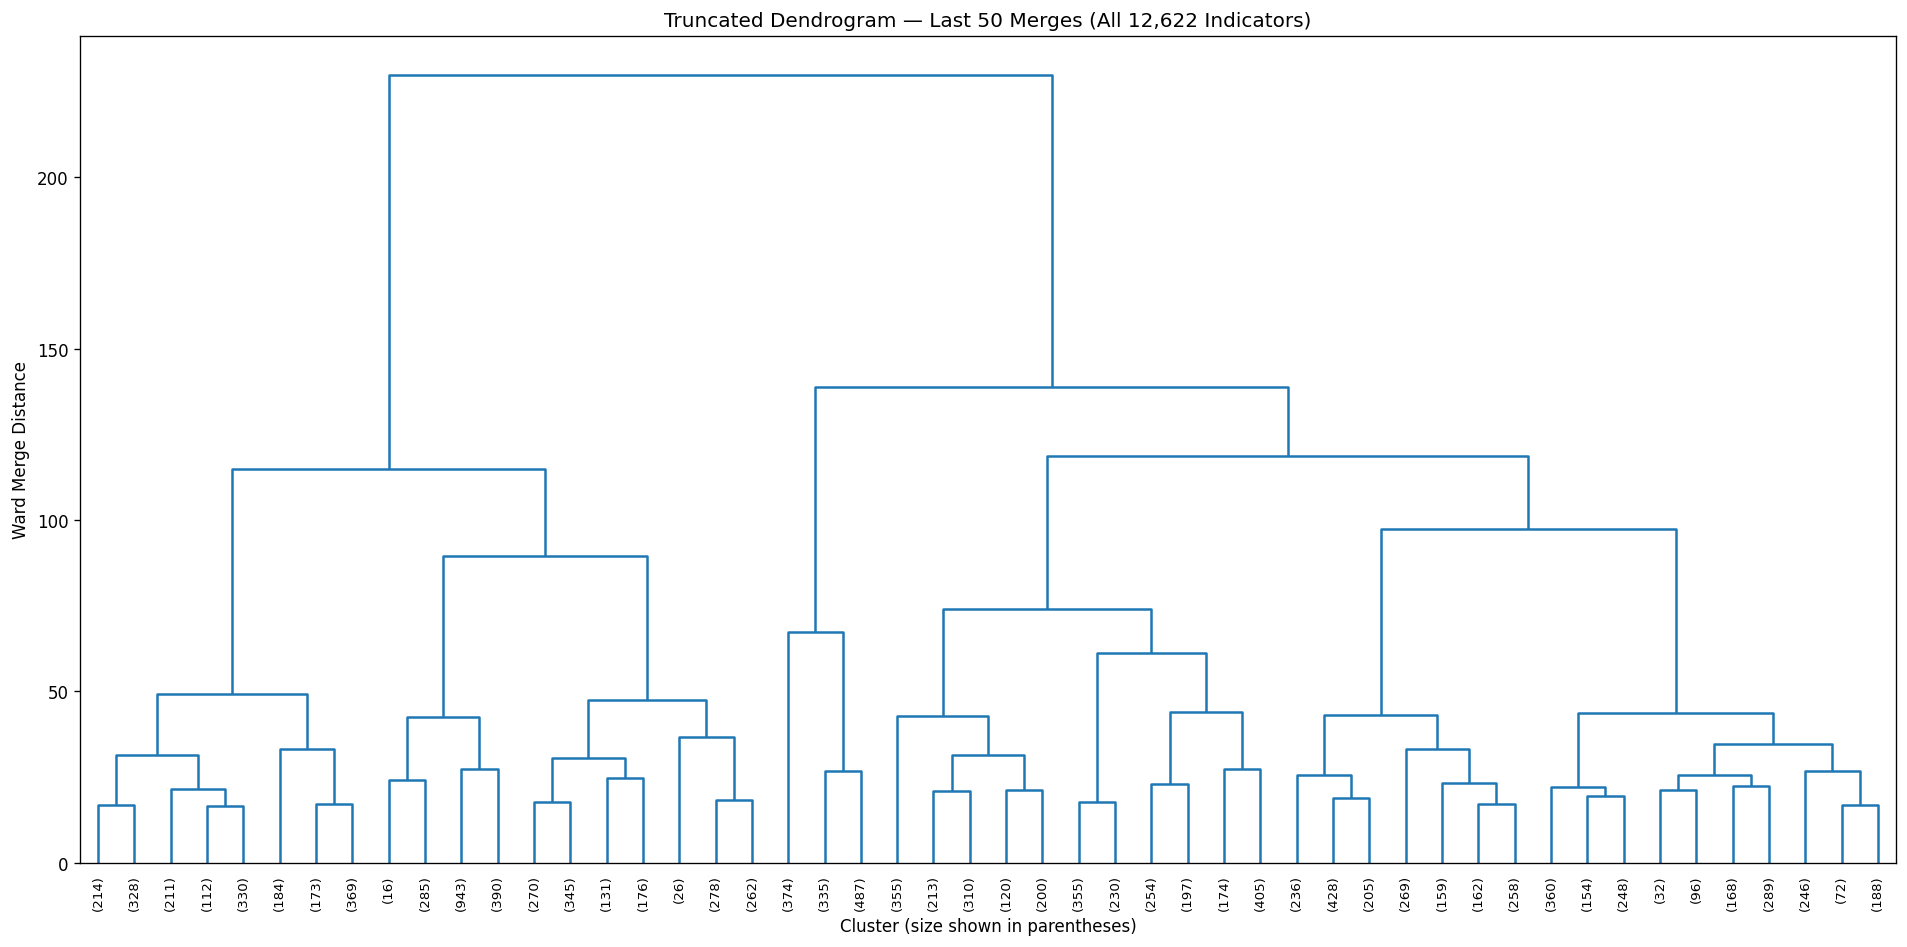

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/dendrogram_truncated_top50.png

Centroid matrix shape: (34, 10)


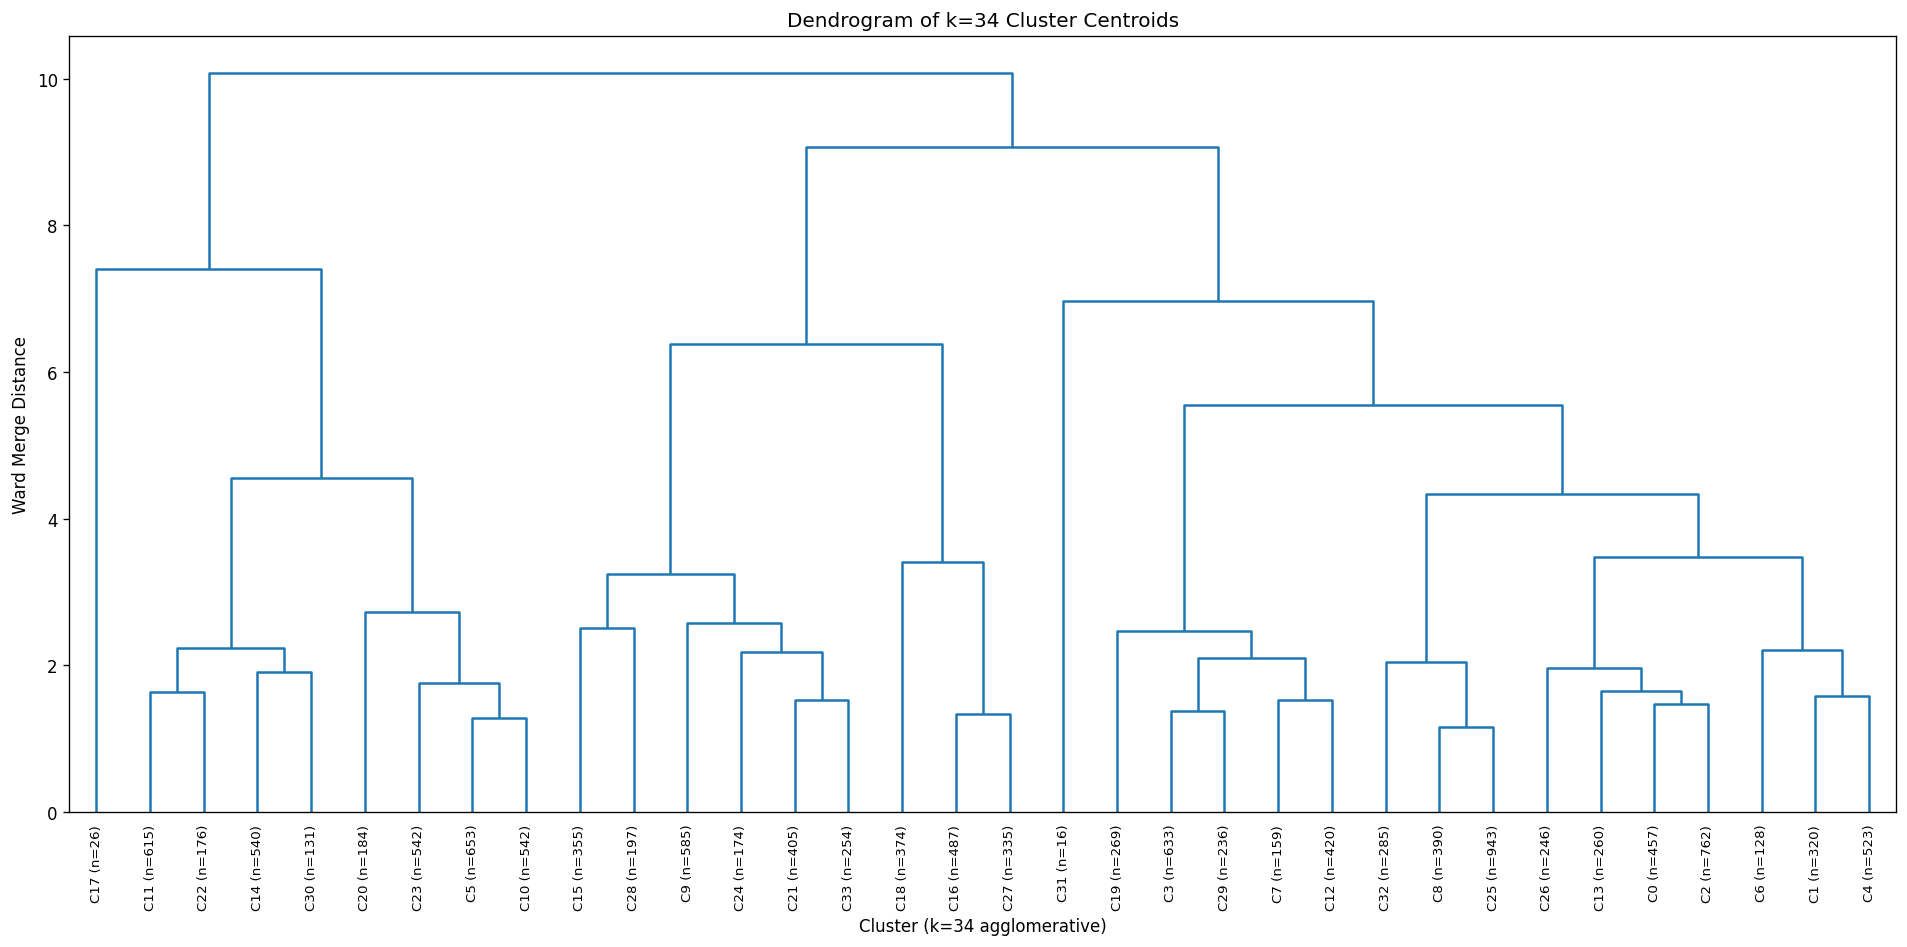

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/dendrogram_k34_centroids.png


In [13]:
# --- Approach A: Truncated Dendrogram (Full Data) ---
# Compute Ward's linkage on all 10D UMAP embeddings.
# This produces the full merge tree for all 12,622 indicators.
print('Computing Ward linkage on all indicators (this may take a minute)...')
Z = linkage(embeddings_10d, method='ward')
print(f'Linkage matrix shape: {Z.shape}')  # (n-1, 4)
print(f'Final merge distance: {Z[-1, 2]:.2f}')

# Truncated dendrogram: show only the last 50 merges.
# Each leaf in this view represents a pre-formed cluster of points,
# with the cluster size shown in parentheses.
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=50,  # show last 50 merges
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax,
    color_threshold=0,  # uniform color for clarity
)
ax.set_xlabel('Cluster (size shown in parentheses)')
ax.set_ylabel('Ward Merge Distance')
ax.set_title('Truncated Dendrogram — Last 50 Merges (All 12,622 Indicators)')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'dendrogram_truncated_top50.png', dpi=150,
            bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "dendrogram_truncated_top50.png"}')

# --- Approach B: Dendrogram of k=34 Cluster Centroids ---
# Compute the centroid (mean embedding) of each of the 34 agglomerative clusters,
# then run hierarchical clustering on those 34 centroids.
k34_labels = agglo_labels_dict[34]
centroids_34 = np.array([
    embeddings_10d[k34_labels == cl].mean(axis=0)
    for cl in range(34)
])
cluster_sizes_34 = [int((k34_labels == cl).sum()) for cl in range(34)]
centroid_labels = [f'C{cl} (n={sz})' for cl, sz in enumerate(cluster_sizes_34)]

print(f'\nCentroid matrix shape: {centroids_34.shape}')  # (34, 10)

# Hierarchical clustering on the 34 centroids
Z_centroids = linkage(centroids_34, method='ward')

fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    Z_centroids,
    labels=centroid_labels,
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax,
    color_threshold=0,
)
ax.set_xlabel('Cluster (k=34 agglomerative)')
ax.set_ylabel('Ward Merge Distance')
ax.set_title('Dendrogram of k=34 Cluster Centroids')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'dendrogram_k34_centroids.png', dpi=150,
            bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "dendrogram_k34_centroids.png"}')

---
## Section 5: Cluster Visualization

We visualize three clustering results in detail:
1. **Agglomerative k=8** — a moderate-coarse view of the embedding space
2. **Agglomerative k=34** — the finest-grained agglomerative result
3. **Best HDBSCAN** — the best density-based result by silhouette score

Each visualization is a scatter plot of the 2D UMAP projection colored by cluster
assignment. This provides a visual check of whether clusters occupy coherent regions
of the embedding space. Per-type overlays (coloring by known wordplay types) are
deferred to Notebook 06, where labeled evaluation is performed.

### Visualization Helper Functions

In [14]:
def plot_clusters(embeddings_2d, labels, title, filename, noise_label=-1):
    """Scatter plot of 2D UMAP colored by cluster assignment."""
    fig, ax = plt.subplots(figsize=(12, 9))

    # Plot noise points first (gray, small)
    noise_mask = labels == noise_label
    if noise_mask.any():
        ax.scatter(
            embeddings_2d[noise_mask, 0],
            embeddings_2d[noise_mask, 1],
            s=1, alpha=0.15, color='lightgray', label='noise', zorder=1
        )

    # Plot clustered points
    non_noise_mask = ~noise_mask
    unique_labels = sorted(set(labels[non_noise_mask]))
    n_clusters = len(unique_labels)

    # Use a colormap with enough distinct colors
    cmap = plt.cm.get_cmap('tab20', max(n_clusters, 20))
    for i, cl in enumerate(unique_labels):
        mask = labels == cl
        ax.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            s=2, alpha=0.4, color=cmap(i % 20), zorder=2
        )

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title(f'{title} ({n_clusters} clusters)')

    if noise_mask.any():
        n_noise = noise_mask.sum()
        ax.annotate(f'Noise: {n_noise} ({n_noise/len(labels)*100:.1f}%)',
                    xy=(0.02, 0.98), xycoords='axes fraction',
                    fontsize=9, va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    fig.savefig(FIGURES_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {FIGURES_DIR / filename}')

### Agglomerative k=8 Visualization

/var/folders/3k/s3lth05j71x9zqxntyjngc0c0000gn/T/ipykernel_5835/4156939200.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(n_clusters, 20))


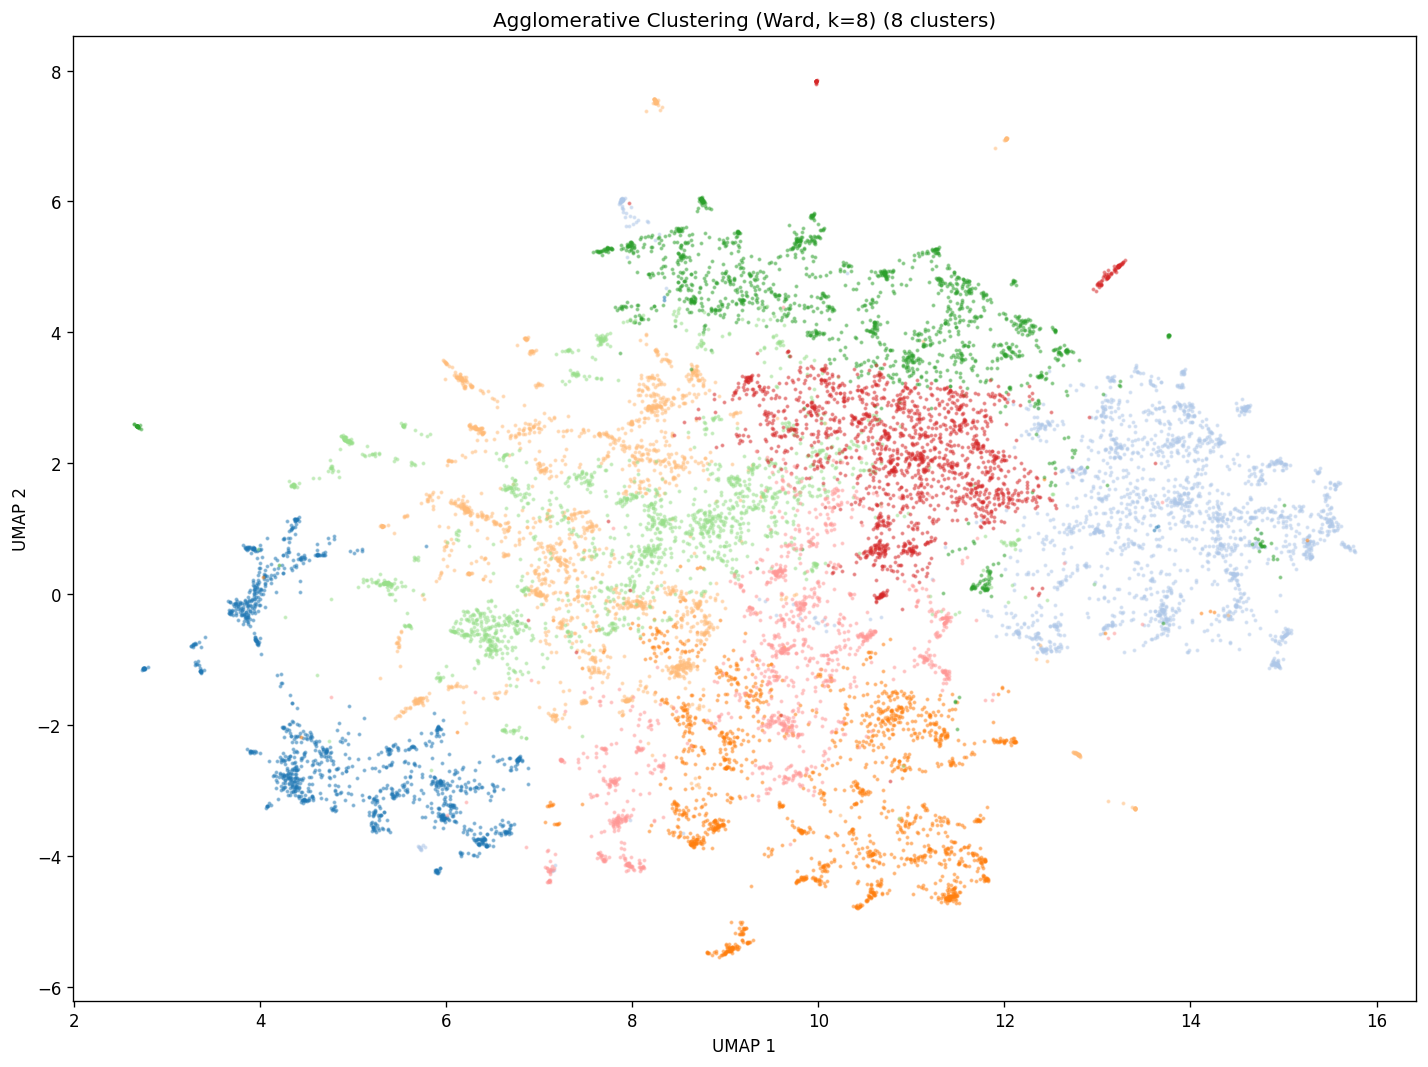

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/agglo_k8_clusters.png


In [15]:
plot_clusters(
    embeddings_2d,
    agglo_labels_dict[8],
    title='Agglomerative Clustering (Ward, k=8)',
    filename='agglo_k8_clusters.png'
)

### Agglomerative k=34 Visualization

/var/folders/3k/s3lth05j71x9zqxntyjngc0c0000gn/T/ipykernel_5835/4156939200.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(n_clusters, 20))


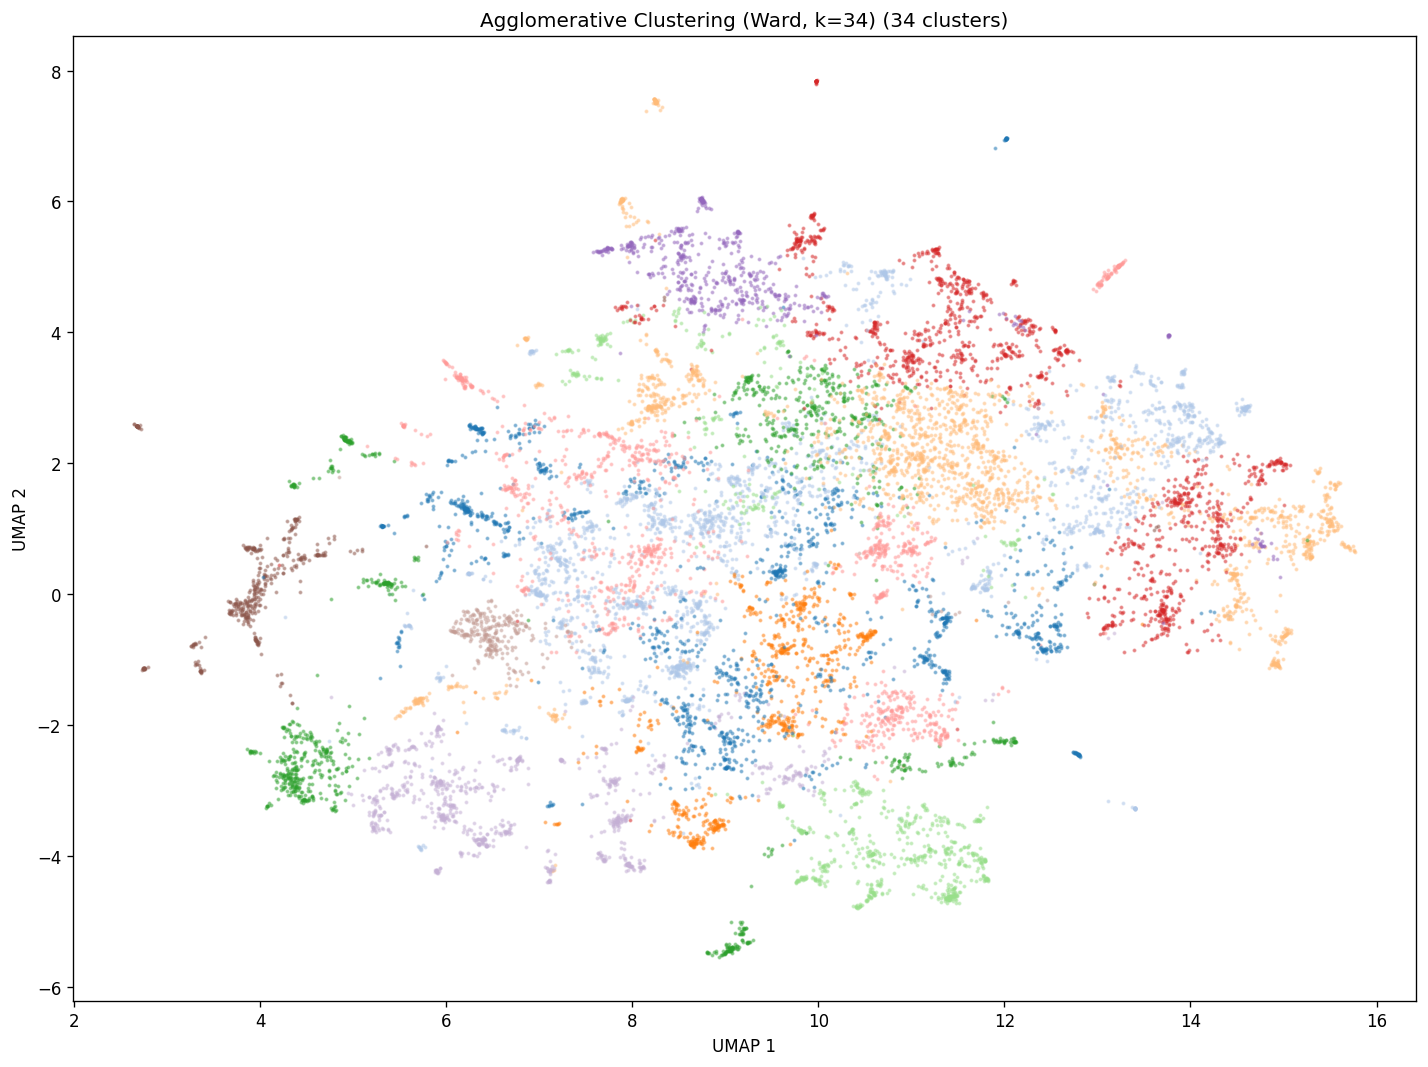

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/agglo_k34_clusters.png


In [16]:
plot_clusters(
    embeddings_2d,
    agglo_labels_dict[34],
    title='Agglomerative Clustering (Ward, k=34)',
    filename='agglo_k34_clusters.png'
)

### Best HDBSCAN Visualization

/var/folders/3k/s3lth05j71x9zqxntyjngc0c0000gn/T/ipykernel_5835/4156939200.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(n_clusters, 20))


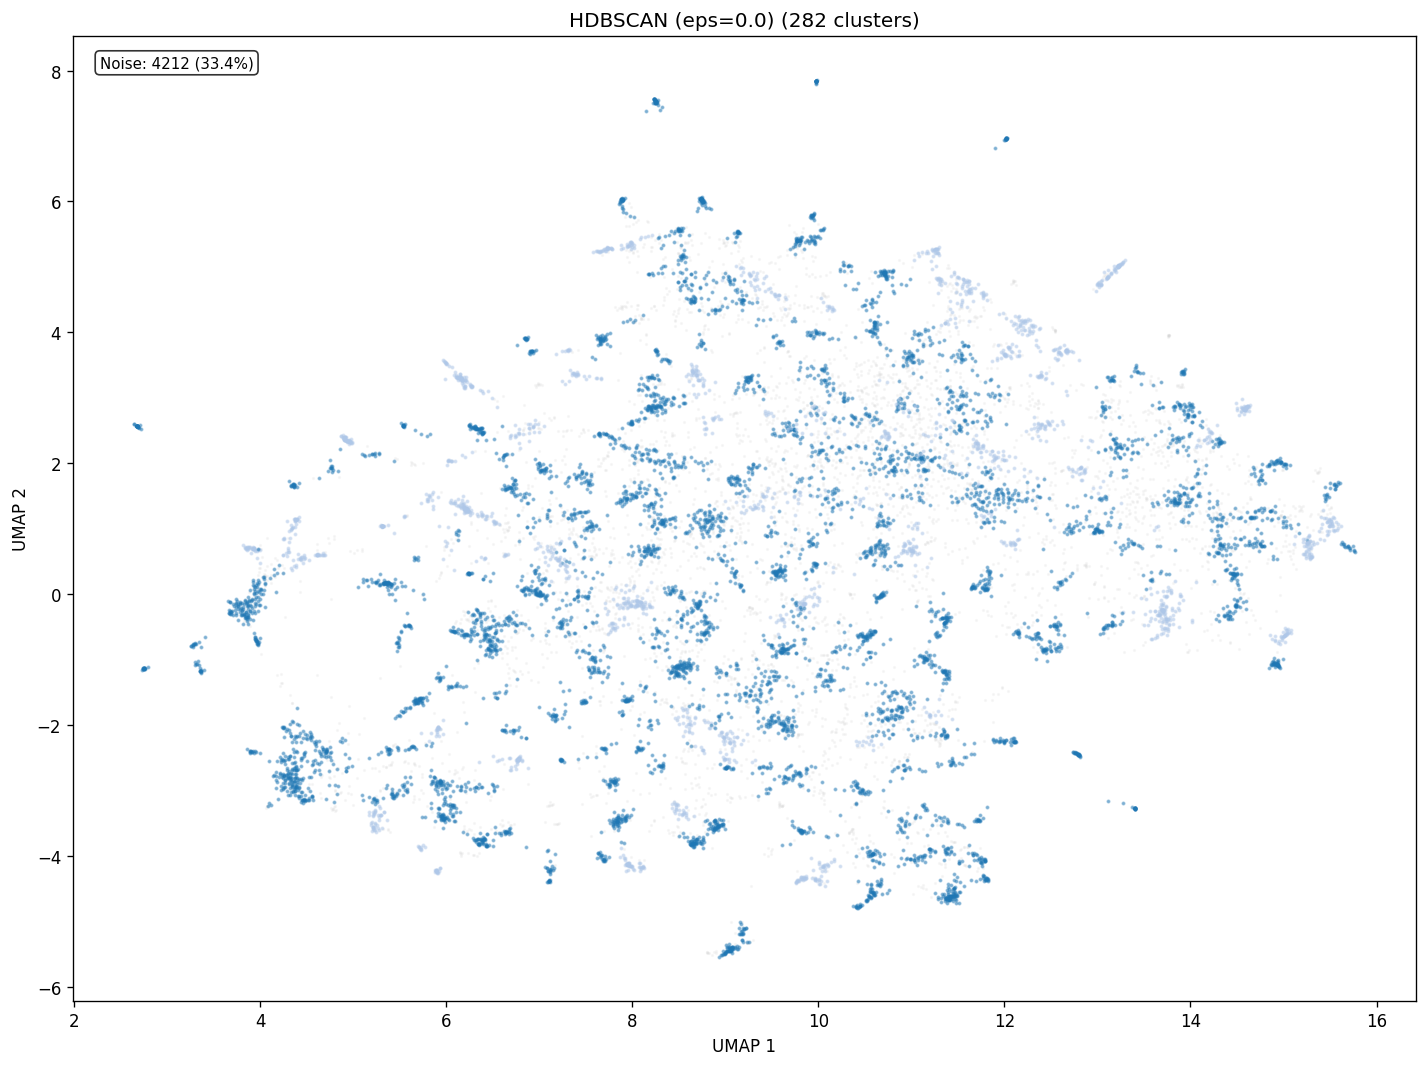

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/hdbscan_best_clusters.png


In [17]:
plot_clusters(
    embeddings_2d,
    best_hdbscan_labels,
    title=f'HDBSCAN (eps={best_eps})',
    filename='hdbscan_best_clusters.png'
)

---
## Section 6: Qualitative Inspection

For each cluster in the agglomerative k=8 and best HDBSCAN runs, we print the 10
indicators closest to the cluster centroid (in 10D UMAP space). This label-free
inspection lets us judge whether clusters are semantically coherent — do the nearest-
to-centroid indicators share a recognizable theme? — without importing any wordplay
type labels. Label-based evaluation is deferred to Notebooks 05 and 06.

In [18]:
def inspect_clusters(labels, embeddings_10d, indicator_names, method_name,
                     n_examples=10):
    """Print centroid-nearest indicators and cluster size per cluster.

    This is a label-free inspection: we look at which indicator strings are
    closest to each cluster's centroid to judge semantic coherence.
    """
    unique_labels = sorted(set(labels))

    for cl in unique_labels:
        if cl == -1:
            # Summarize noise points briefly
            n_noise = (labels == -1).sum()
            print(f'\n{"=" * 60}')
            print(f'{method_name} — Noise points: {n_noise}')
            print(f'{"=" * 60}')
            continue

        mask = labels == cl
        cluster_size = mask.sum()
        cluster_embeddings = embeddings_10d[mask]
        cluster_names = indicator_names[mask]

        # Compute centroid and find nearest points
        centroid = cluster_embeddings.mean(axis=0)
        dists_to_centroid = np.linalg.norm(cluster_embeddings - centroid, axis=1)
        nearest_idx = np.argsort(dists_to_centroid)[:n_examples]
        nearest = [cluster_names[i] for i in nearest_idx]

        print(f'\n{"=" * 60}')
        print(f'{method_name} — Cluster {cl} (n={cluster_size})')
        print(f'{"-" * 60}')
        print(f'Nearest to centroid: {", ".join(nearest)}')

### Agglomerative k=8 — Cluster Inspection

In [19]:
inspect_clusters(
    agglo_labels_dict[8],
    embeddings_10d,
    indicator_names,
    method_name='Agglomerative k=8'
)


Agglomerative k=8 — Cluster 0 (n=1196)
------------------------------------------------------------
Nearest to centroid: in rehab, cured, recovered from, after resettlement, following rehab, rediscovered, retrieving, recovered, retrieved, recovery

Agglomerative k=8 — Cluster 1 (n=1921)
------------------------------------------------------------
Nearest to centroid: profligate, perverse, perversely, travesty, preposterous, promiscuously, promiscuous, pervertedly, precariously, errant

Agglomerative k=8 — Cluster 2 (n=1615)
------------------------------------------------------------
Nearest to centroid: as an anagram, anagram, anagrams, as a, as herbal, cast of, as a show of, cast in, featured, cast

Agglomerative k=8 — Cluster 3 (n=1853)
------------------------------------------------------------
Nearest to centroid: must encase, must be caught, into care of, must be gripped by, must plug, must catch, must be put in, it takes, must be beaten, must be found in

Agglomerative k=8 — C

### Best HDBSCAN — Cluster Inspection

HDBSCAN may produce many clusters. We inspect the 15 largest clusters to keep
output manageable. A full inspection of all clusters belongs in Notebook 05.

In [20]:
# For HDBSCAN, inspect only the largest clusters to keep output concise
unique_hdbscan_labels = sorted(set(best_hdbscan_labels))
n_hdbscan_clusters = len([l for l in unique_hdbscan_labels if l != -1])

if n_hdbscan_clusters > 15:
    # Find the 15 largest clusters by size
    cluster_sizes = pd.Series(best_hdbscan_labels[best_hdbscan_labels != -1]).value_counts()
    top_15_labels = set(cluster_sizes.head(15).index)

    # Create a filtered label array: keep top 15, set rest to -1
    filtered_labels = np.where(
        np.isin(best_hdbscan_labels, list(top_15_labels)),
        best_hdbscan_labels,
        -1
    )
    print(f'HDBSCAN found {n_hdbscan_clusters} clusters. '
          f'Showing the 15 largest below.')
    inspect_clusters(
        filtered_labels,
        embeddings_10d,
        indicator_names,
        method_name=f'HDBSCAN (eps={best_eps})'
    )
else:
    inspect_clusters(
        best_hdbscan_labels,
        embeddings_10d,
        indicator_names,
        method_name=f'HDBSCAN (eps={best_eps})'
    )

HDBSCAN found 282 clusters. Showing the 15 largest below.

HDBSCAN (eps=0.0) — Noise points: 11084

HDBSCAN (eps=0.0) — Cluster 21 (n=133)
------------------------------------------------------------
Nearest to centroid: bringing back, to return, getting back, to bring back, to come back, to return in, to get back, about to go back, coming back in, needing to go back

HDBSCAN (eps=0.0) — Cluster 28 (n=69)
------------------------------------------------------------
Nearest to centroid: turned, turned to, gets turned, turn to, turning, turning turtle, stomach turning, having turned, after turning, in turn

HDBSCAN (eps=0.0) — Cluster 51 (n=273)
------------------------------------------------------------
Nearest to centroid: getting reinvented, retrofit, being reselected, retuned, to be reappointed to, reinvention, redesign, being rebuilt, rebuilt, retrained

HDBSCAN (eps=0.0) — Cluster 53 (n=64)
------------------------------------------------------------
Nearest to centroid: changes, 

---
## Section 7: Save All Outputs

We save cluster labels for every run so that downstream notebooks can load and evaluate
them without rerunning the clustering. Each CSV has columns `indicator` and `cluster_label`.

**Output files:**

| File | Location | Description |
|------|----------|-------------|
| `cluster_labels_hdbscan_eps_{value}.csv` | `DATA_DIR` | Labels per HDBSCAN epsilon run |
| `cluster_labels_agglo_k{value}.csv` | `DATA_DIR` | Labels per agglomerative k |
| `clustering_metrics_summary.csv` | `OUTPUT_DIR` | All metrics from all runs |
| `pairwise_distance_distribution.png` | `FIGURES_DIR` | Distance histogram |
| `hdbscan_epsilon_sensitivity.png` | `FIGURES_DIR` | HDBSCAN sensitivity analysis |
| `agglo_k8_clusters.png` | `FIGURES_DIR` | Agglomerative k=8 scatter plot |
| `agglo_k34_clusters.png` | `FIGURES_DIR` | Agglomerative k=34 scatter plot |
| `hdbscan_best_clusters.png` | `FIGURES_DIR` | Best HDBSCAN scatter plot |
| `dendrogram_truncated_top50.png` | `FIGURES_DIR` | Truncated dendrogram (full data) |
| `dendrogram_k34_centroids.png` | `FIGURES_DIR` | Dendrogram of k=34 centroids |

In [21]:
# Save HDBSCAN cluster labels for each epsilon
for eps, labels in hdbscan_labels_dict.items():
    eps_str = f'{eps:.4f}'.replace('.', 'p')  # e.g., 0.1500 -> 0p1500
    fname = f'cluster_labels_hdbscan_eps_{eps_str}.csv'
    out_df = pd.DataFrame({
        'indicator': indicator_names,
        'cluster_label': labels,
    })
    out_df.to_csv(DATA_DIR / fname, index=False)
    print(f'Saved: {fname}')

Saved: cluster_labels_hdbscan_eps_0p0000.csv
Saved: cluster_labels_hdbscan_eps_0p7788.csv
Saved: cluster_labels_hdbscan_eps_1p4980.csv
Saved: cluster_labels_hdbscan_eps_1p9327.csv
Saved: cluster_labels_hdbscan_eps_2p2334.csv
Saved: cluster_labels_hdbscan_eps_2p4729.csv
Saved: cluster_labels_hdbscan_eps_2p6847.csv


In [22]:
# Save agglomerative cluster labels for each k
for k, labels in agglo_labels_dict.items():
    fname = f'cluster_labels_agglo_k{k}.csv'
    out_df = pd.DataFrame({
        'indicator': indicator_names,
        'cluster_label': labels,
    })
    out_df.to_csv(DATA_DIR / fname, index=False)
    print(f'Saved: {fname}')

Saved: cluster_labels_agglo_k6.csv
Saved: cluster_labels_agglo_k8.csv
Saved: cluster_labels_agglo_k12.csv
Saved: cluster_labels_agglo_k26.csv
Saved: cluster_labels_agglo_k34.csv


In [23]:
# Build a combined metrics summary for all runs
all_metrics = []

# HDBSCAN runs
for _, row in df_hdbscan.iterrows():
    all_metrics.append({
        'method': 'HDBSCAN',
        'parameters': f'min_cluster_size=10, eps={row["epsilon"]}',
        'n_clusters': int(row['n_clusters']),
        'n_noise': int(row['n_noise']),
        'noise_pct': row['noise_pct'],
        'silhouette': row['silhouette'],
        'davies_bouldin': row['davies_bouldin'],
        'calinski_harabasz': float('nan'),  # not computed for HDBSCAN (noise points)
    })

# Agglomerative runs
for _, row in df_agglo.iterrows():
    all_metrics.append({
        'method': 'Agglomerative (Ward)',
        'parameters': f'k={int(row["k"])}',
        'n_clusters': int(row['k']),
        'n_noise': 0,
        'noise_pct': 0.0,
        'silhouette': row['silhouette'],
        'davies_bouldin': row['davies_bouldin'],
        'calinski_harabasz': row['calinski_harabasz'],
    })

df_all_metrics = pd.DataFrame(all_metrics)
metrics_path = OUTPUT_DIR / 'clustering_metrics_summary.csv'
df_all_metrics.to_csv(metrics_path, index=False)

print(f'Saved: {metrics_path}')
print(f'\n--- Full Metrics Summary ---')
print(df_all_metrics.to_string(index=False))

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/clustering_metrics_summary.csv

--- Full Metrics Summary ---
              method                      parameters  n_clusters  n_noise  noise_pct  silhouette  davies_bouldin  calinski_harabasz
             HDBSCAN    min_cluster_size=10, eps=0.0         282     4212  33.370306    0.630992        0.470028                NaN
             HDBSCAN min_cluster_size=10, eps=0.7788          11      114   0.903185   -0.185984        0.775157                NaN
             HDBSCAN  min_cluster_size=10, eps=1.498           4        0   0.000000    0.230049        0.549086                NaN
             HDBSCAN min_cluster_size=10, eps=1.9327           4        0   0.000000    0.230049        0.549086                NaN
             HDBSCAN min_cluster_size=10, eps=2.2334           3        0   0.000000    0.385651        0.461465                NaN
             HDBSCAN min_cluster_size=10, eps=2.4729           3      

In [24]:
# Final file listing
print('=== All Output Files ===')
print(f'\nCluster labels (in {DATA_DIR}):')
for f in sorted(DATA_DIR.glob('cluster_labels_*.csv')):
    print(f'  {f.name}')

print(f'\nMetrics summary (in {OUTPUT_DIR}):')
print(f'  clustering_metrics_summary.csv')

print(f'\nFigures (in {FIGURES_DIR}):')
for f in sorted(FIGURES_DIR.glob('*.png')):
    print(f'  {f.name}')

print('\nDone. All outputs saved for Notebook 05.')

=== All Output Files ===

Cluster labels (in /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/data):
  cluster_labels_agglo_k12.csv
  cluster_labels_agglo_k26.csv
  cluster_labels_agglo_k34.csv
  cluster_labels_agglo_k6.csv
  cluster_labels_agglo_k8.csv
  cluster_labels_hdbscan_eps_0p0000.csv
  cluster_labels_hdbscan_eps_0p7788.csv
  cluster_labels_hdbscan_eps_1p4980.csv
  cluster_labels_hdbscan_eps_1p9327.csv
  cluster_labels_hdbscan_eps_2p2334.csv
  cluster_labels_hdbscan_eps_2p4729.csv
  cluster_labels_hdbscan_eps_2p6847.csv

Metrics summary (in /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs):
  clustering_metrics_summary.csv

Figures (in /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures):
  agglo_k34_clusters.png
  agglo_k8_clusters.png
  agglo_k8_ho_alternation.png
  agglo_k8_ho_anagram.png
  agglo_k8_ho_container.png
  agglo_k8_ho_deletion.png
  agglo_k8_ho_hidden.png
  agglo_k8_ho_homophone.png
  agglo_k8_ho_inserti

---
## Interpretation of Results

### HDBSCAN Epsilon Sensitivity

The epsilon sweep reveals a sharp transition with no stable middle ground. At epsilon=0,
HDBSCAN finds many tight clusters but discards roughly a third of points as noise. As
epsilon increases, clusters merge rapidly — there is no epsilon value that produces a
moderate number of clusters (e.g., 8-20) with reasonable noise levels. This means the
data has strong local structure (tight variant-level clumps) but no clear intermediate
grouping level that emerges naturally from density alone.

The high silhouette score at low epsilon is partly an artifact of discarding many points
as noise, as KCT warned. HDBSCAN is only grading itself on the easy cases. Many noise
points form visible clumps in the 2D UMAP projection but fall below the min_cluster_size
threshold or lack sufficient density in the full 10D space.

### Agglomerative Metrics Across k Values

Silhouette scores increase with k (higher at k=34 than at k=6), while Davies-Bouldin
decreases. Finer granularity consistently fits the data better, suggesting the natural
structure of indicator embeddings is more granular than 6-8 clusters. This is consistent
with the HDBSCAN finding of many natural clusters at epsilon=0.

### Qualitative Cluster Coherence

The centroid-nearest inspection reveals whether clusters are semantically coherent at
each granularity. At k=8, clusters tend to be broad mixtures of indicators with
different semantic themes. At k=34 and in fine-grained HDBSCAN, clusters become more
semantically focused — the nearest-to-centroid indicators often share a recognizable
conceptual theme (e.g., a cluster of movement words, a cluster of hearing words, a
cluster of containment words).

### Dendrogram Structure

The dendrograms reveal the hierarchical relationships between clusters. The truncated
dendrogram of the full data shows the merge distances at the top of the tree, indicating
whether there are natural "cut points" — large gaps in merge distance that suggest a
preferred number of clusters. The centroid-based dendrogram shows how the 34 finest-
grained agglomerative clusters relate to each other and which would merge first if we
reduced k.

### What This Notebook Does NOT Tell Us

This notebook deliberately avoids using wordplay type labels or domain knowledge. We
cannot yet say whether any cluster corresponds to "anagram" or "homophone" — that
evaluation requires comparing cluster assignments to known labels, which happens in
Notebooks 05 and 06. What we can say is:

1. The data has strong local structure at fine granularity
2. No natural intermediate grouping (k=8-20) emerges from either density-based or
   hierarchical methods
3. Finer-grained clusterings produce better metric scores
4. Clusters are semantically coherent when examined qualitatively

These findings set up the question for Notebook 05: can domain knowledge (seed words,
constrained clustering) help us find wordplay-type-level structure that does not emerge
on its own?